In [1]:
import sys, os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
# from typing import Iterable, List
# from torch.nn.parameter import Parameter
# import torchvision
# from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# import collections
import pandas as pd 
import numpy as np
import random 
import scanpy as sc
from scipy.io import mmread

from model import Encoder, Decoder, OutputLayer
from loss_function import ZINB, maximum_mean_discrepancy
from train import train_epoch, test_epoch
from utils import plot_train


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class dataset(Dataset):
    """\
        Description:
        ------------
            Create Pytorch Dataset

        Parameters:
        ------------
            counts: gene count. Type: numpy ndarrary
            anno: cell type annotations of the cells, of the shape the same as number of cells
        Return:
        ------------
            Dataset
        """
    def __init__(self, counts, anno = None):

        assert not len(counts) == 0, "Count is empty"
        self.counts = torch.FloatTensor(counts)
        if anno is None:
            self.anno = None
        else:
            self.anno = anno
                   
    def __len__(self):
        return self.counts.shape[0]
    
    def __getitem__(self, idx):
        if self.anno is not None:
            sample = {"count": self.counts[idx,:], "anno": self.anno[idx]}
        else:
            sample = {"count": self.counts[idx,:]}
        return sample

## Loading the dataset
We have three batches, from day 2, 4, and 7. We hope to integrate cells from 3 batches, which is to make the latent embedding of cells from three batches merge.

In [2]:
# Data
path_pool = [
    r"./data/mtx_0.mtx", 
    r'./data/GSE65525/GSM1599497_ES_d2_LIFminus.csv', 
    r'./data/GSE65525/GSM1599498_ES_d4_LIFminus.csv', 
    r'./data/GSE65525/GSM1599499_ES_d7_LIFminus.csv'
    ]

data_test= sc.read_csv(path_pool[2])

# the latent embedding of three batches should be merged
# batch 1, from day 2
counts_d2 = pd.read_csv("./data/GSE65525/GSM1599497_ES_d2_LIFminus.csv", index_col = 0, header = None).T
# batch 2, from day 4
counts_d4 = pd.read_csv("./data/GSE65525/GSM1599498_ES_d4_LIFminus.csv", index_col = 0, header = None).T
# batch 3, from day 7
counts_d7 = pd.read_csv("./data/GSE65525/GSM1599499_ES_d7_LIFminus.csv", index_col = 0, header = None).T

anno_d2 = np.array(["Day 2"] * counts_d2.shape[0])
anno_d4 = np.array(["Day 4"] * counts_d4.shape[0])
anno_d7 = np.array(["Day 7"] * counts_d7.shape[0])

anno = np.concatenate([anno_d2, anno_d4, anno_d7], axis = 0)

In [3]:
# PREVIEW
load_data = data_test.T.copy()
sc.pp.filter_genes(load_data, min_cells=50)
print('Original data size:', data_test.shape, '| Input data size:', load_data.shape)

Original data size: (24175, 683) | Input data size: (683, 7670)


In [4]:
batch_size = 50
all_data = np.array(load_data.X)

seed = 222
random.seed(seed)

m = len(all_data)
print(m)

# no need to split train and test data for data integration
# train_data, test_data = random_split(dataset=all_data, lengths=[int(m - m * 0.2), int(m * 0.2) + 1])
# train_loader = DataLoader(train_data, batch_size=batch_size)
# test_loader = DataLoader(test_data, batch_size=batch_size)

# construct training and testing dataset for one batch (day 4)
train_data = dataset(counts = all_data, anno = anno_d4)
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(train_data, batch_size = train_data.counts.shape[0], shuffle = False)

683


In [5]:
net_struc = [all_data.shape[1], 1024, 256, 64, 32]

encoder = Encoder(features=net_struc).to(device)
decoder = Decoder(features=net_struc[1:][::-1]).to(device)

# Three output layer of DCA
# dropoutRates = {'mean': 0.1, 'pi': 0.1, 'theta': 0.1}
output_layer = OutputLayer(net_struc[:2][::-1]).to(device)

# Define Optimizer
lr = 5e-5

#Random seed
torch.manual_seed(seed)
param_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(param_to_optimize, lr=lr)

In [51]:
factor_zinb = 0.5
factor_mmd = 1

## Training issue
* The **MMD loss** can only be calculated **between two batches**: either day 2 & 4, or day 4 & 7, or day 2 & 7
* but here we only have one day, which is day 4


 EPOCH 1/50 	 train loss 0.13102497293519763 	 test loss 0.021133774719685097

 EPOCH 2/50 	 train loss 0.13111517335101416 	 test loss 0.02065215383057713

 EPOCH 3/50 	 train loss 0.1310076643746908 	 test loss 0.02020302209812237

 EPOCH 4/50 	 train loss 0.1309690587168033 	 test loss 0.019739299008996385

 EPOCH 5/50 	 train loss 0.13102473137493886 	 test loss 0.019169926119758304


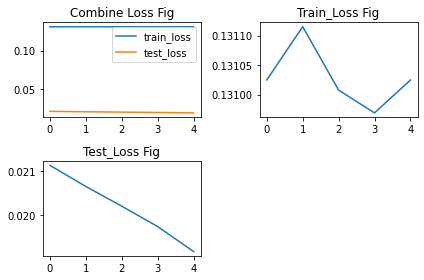


 EPOCH 6/50 	 train loss 0.13101170457474134 	 test loss 0.018466446794144057

 EPOCH 7/50 	 train loss 0.1310030649556597 	 test loss 0.017625912042173775

 EPOCH 8/50 	 train loss 0.1309215188200966 	 test loss 0.016355943191103846

 EPOCH 9/50 	 train loss 0.1310893410644978 	 test loss 0.014936747348500555

 EPOCH 10/50 	 train loss 0.13080975112244814 	 test loss 0.013559629068891266


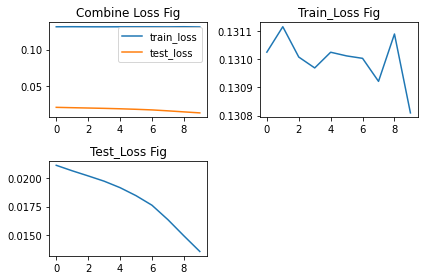


 EPOCH 11/50 	 train loss 0.13078974141557953 	 test loss 0.012375034315519767

 EPOCH 12/50 	 train loss 0.1308843625237617 	 test loss 0.01132611404575331

 EPOCH 13/50 	 train loss 0.1308877960305612 	 test loss 0.01012213652514434

 EPOCH 14/50 	 train loss 0.13075974814888325 	 test loss 0.009429107822401457

 EPOCH 15/50 	 train loss 0.1308645894900946 	 test loss 0.009002390228986391


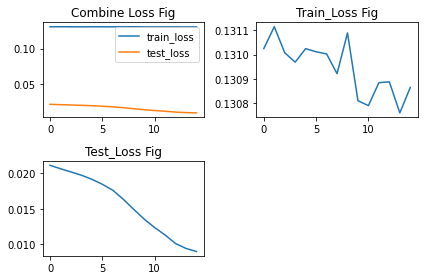


 EPOCH 16/50 	 train loss 0.13075281481093579 	 test loss 0.008727128125214471

 EPOCH 17/50 	 train loss 0.13076328777464033 	 test loss 0.008564320001560283

 EPOCH 18/50 	 train loss 0.13077739252003884 	 test loss 0.00842578658945913

 EPOCH 19/50 	 train loss 0.13085270346869138 	 test loss 0.00834104780920428

 EPOCH 20/50 	 train loss 0.13081056795916132 	 test loss 0.008284751702192762


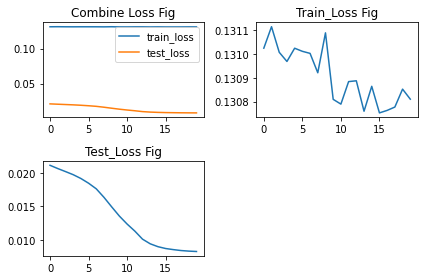


 EPOCH 21/50 	 train loss 0.13080158903867573 	 test loss 0.008270302768333066

 EPOCH 22/50 	 train loss 0.13075574983789492 	 test loss 0.008260490953660465

 EPOCH 23/50 	 train loss 0.1308338917890021 	 test loss 0.008246673148338128

 EPOCH 24/50 	 train loss 0.1308231493389973 	 test loss 0.008228391365285848

 EPOCH 25/50 	 train loss 0.13083251294070422 	 test loss 0.008234674026466916


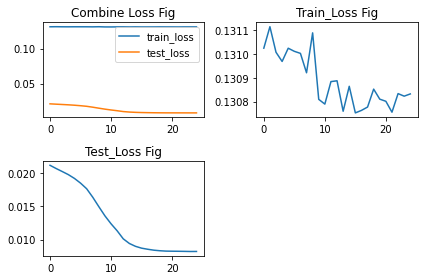


 EPOCH 26/50 	 train loss 0.13087194451126835 	 test loss inf

 EPOCH 27/50 	 train loss 0.13083871950342227 	 test loss inf

 EPOCH 28/50 	 train loss 0.13090826372451 	 test loss inf

 EPOCH 29/50 	 train loss 0.1309327346165044 	 test loss inf

 EPOCH 30/50 	 train loss 0.13092323347904322 	 test loss inf


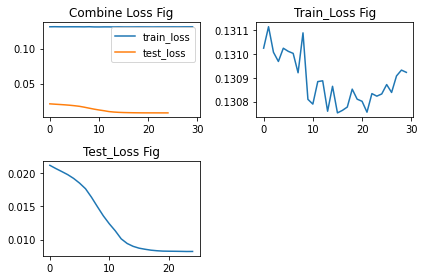


 EPOCH 31/50 	 train loss 0.13081707751942936 	 test loss inf

 EPOCH 32/50 	 train loss 0.1308565426012433 	 test loss inf

 EPOCH 33/50 	 train loss 0.13076284584503398 	 test loss inf

 EPOCH 34/50 	 train loss 0.1308216999774447 	 test loss inf

 EPOCH 35/50 	 train loss 0.1309245704382789 	 test loss inf


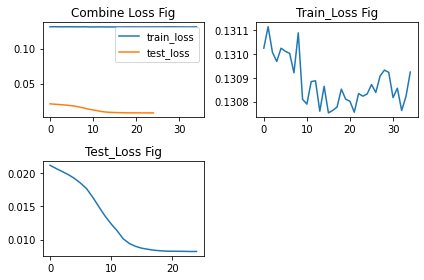


 EPOCH 36/50 	 train loss 0.13082210350874401 	 test loss inf

 EPOCH 37/50 	 train loss 0.13088433110696504 	 test loss inf

 EPOCH 38/50 	 train loss 0.13060445143223506 	 test loss inf

 EPOCH 39/50 	 train loss 0.13068969567384064 	 test loss inf

 EPOCH 40/50 	 train loss 0.13078060052405338 	 test loss inf


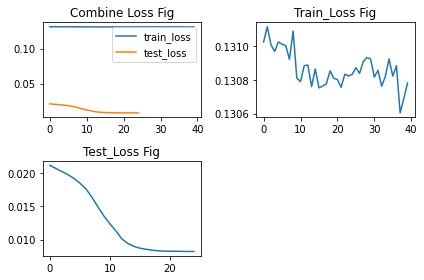


 EPOCH 41/50 	 train loss 0.13073239947831475 	 test loss inf

 EPOCH 42/50 	 train loss 0.13063997894220086 	 test loss inf

 EPOCH 43/50 	 train loss 0.13077531272809992 	 test loss inf

 EPOCH 44/50 	 train loss 0.13058416316310273 	 test loss inf

 EPOCH 45/50 	 train loss 0.13071880438317318 	 test loss inf


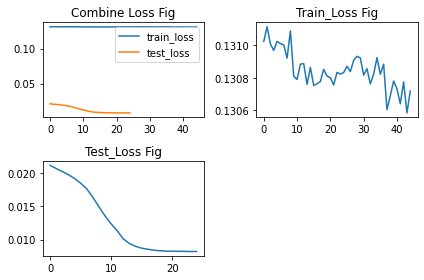


 EPOCH 46/50 	 train loss 0.13057062671264827 	 test loss inf

 EPOCH 47/50 	 train loss 0.1306346729943204 	 test loss inf

 EPOCH 48/50 	 train loss 0.1306236233578594 	 test loss inf

 EPOCH 49/50 	 train loss 0.1304324675095029 	 test loss inf

 EPOCH 50/50 	 train loss 0.1304690583034979 	 test loss inf


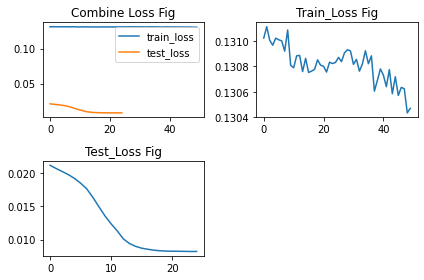

In [54]:
num_epochs = 50
all_loss = {'train_loss':[],'test_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(encoder,decoder,output_layer,train_loader,optim,factor_zinb,factor_mmd)
    test_loss = test_epoch(encoder,decoder,output_layer,test_loader,factor_zinb,factor_mmd)
    print('\n EPOCH {}/{} \t train loss {} \t test loss {}'.format(epoch + 1, num_epochs,train_loss,test_loss))
    all_loss['train_loss'].append(train_loss)
    all_loss['test_loss'].append(test_loss)
    if epoch and (epoch + 1) % 5 == 0:
        plot_train(all_loss, seperate=True)

## Visualize the latent embedding
After training is done, extract the latent embedding out and plot it

Here I write a sample code as below

Text(0, 0.5, 'UMAP 2')

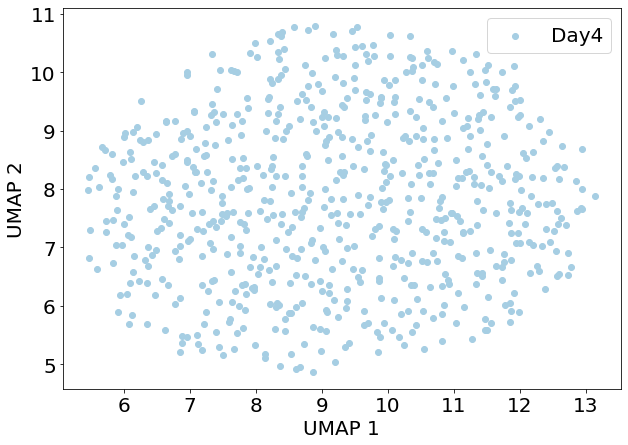

In [21]:
from umap import UMAP
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20

umap_op = UMAP(n_components = 2, min_dist = 0.4, random_state = 0)
for data in test_loader:
    z = encoder(data["count"].to(device))

z_umap = umap_op.fit_transform(z.detach().cpu().numpy())

# plot the figure
# number of clusters within one batch, here we use 1 because we don't have cluster label within one batch for now
n_clust = 1
clust_color = plt.cm.get_cmap("Paired", n_clust)
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot()
ax.scatter(z_umap[:,0], z_umap[:, 1], color = clust_color(0), label = "Day4")
ax.legend()
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")